
    Script to run filtering and alignment of ribosome footprint sequencing data
    Copyright (C) 2019  Fuad Mohammad, fuadm424@gmail.com


    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
    


# FASTQ processing script

This notebook will take FASTQ files from Ribo-seq or RNA-seq and convert them to density files aligned to a genome using the 3' end of genes. 

- Filtering is done using skewer v0.2.2 to remove low quality reads and reads outside of size threshold.
- Bowtie v0.12.7 removes any contaminating ladder, tRNA, and rRNA. Aligns reads with an allowed mismatch of 2.
- Density is made using 3' alignment. It is stored as a pickled dictionary and is size separated. It is also saved as a .wig file and a .bin file for convenience. 
- Script will output library statistics including filtering and bowtie read allocation, as well as some custom QC information. 

Generally, I save this script as an HTML file alongside the density file for reference.

Input and paths are placed in dictionaries. Libraries are numbered as initials + library number (FM1, FM2...)

# Settings


In [1]:
%load_ext autoreload
%autoreload 2
import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot



'''Settings and Inputs'''

library_creator = 'TA'        # FM, KS, CW, Menkin, Li, etc... (initial of who made it)
organism        = 'Coli'      # Coli, Subtilis, Tuberculosis, Volcanii etc...

inputs = {
    
    'files' : [library_creator + str(i) for i in range(9, 12 + 1)],       #Files to analyze
    
    # for data renaming: useful to rename files from seq_facility - can be ignored
    'order_name' : 'abuskir1_152243_FM107',    # to rename/concat FASTQ if needed, else set to 'none' or ignore
    
    'data_type'  : 'ribo_seq',  # Type of library: ribo_seq or RNA_seq
    
    # select which functions to run: 'yes' and 'no' 
    'run_filtering': 'yes',
    'run_bowtie'   : 'yes',
    'run_density'  : 'yes',
    'run_readQC'   : 'yes',
    
    # cuttoff for readsize and quality for filtering and density
    'minlength'    : 10,
    'maxlength'    : 40,
    'phred_cutoff' : 10,
                        
    # linker-1 for FM = CTGTAGGCACCATCAATAGATCGGAAGAGCACACGTCTGAACTCCAGTCA
    # for SM          = CTGTAGGCACCATCAATTCGTATGCCGTCTTCTGCTTG
    # Gross           = CTGTAGGCACCATCAATATCTCGTATGCCGTCTTCTGCTTG
    # Zoya            = ATCTCGTATGCCGTCTTCTGCTTG
    'linker'       :   'CTGTAGGCACCATCAATAGATCGGAAGAGCACACGTCTGAACTCCAGTCA',
                      
    
    # CPU information for multithreading applications, 
    'multiprocess' : 'yes',
    'threads'      : 8,
    'cores'        : 4,     
    }


gff_settings = {
    'path_out'         : 0,
    'feat_of_interest' : 'CDS',         #all, CDS, tRNA, rRNA
    'name_qual'        : 'Name',
    'name_qual_alt'    : 'gene_id',
    'remove_genes'     : 'yes',         #remove hard to align genes, if no, will add annotation 
    'aSD_seq'          : 'TCCTCC'
    }





In [2]:
'''Input directories'''
# Can be customized to your liking 

path_pc     = '/Volumes/HDD/Ribo_seq/'
inpath      = path_pc + 'libraries/'
path_script = '/Users/fuad/Dropbox/'

paths_in = {
    'fastq_download' : inpath  + 'FASTQ/downloaded/',
    'path_fastq'     : inpath  + 'FASTQ/' + library_creator + '/',
    'path_gff'       : path_pc + 'annotations/'+organism+'/'+organism+'.gff',
    'path_gff_dict'  : path_pc + 'annotations/'+organism+'/'+organism+'_dict',   #will be made from GFF
    'path_bowtie'    : path_script + 'scripts/ribo_seq/bowtie/bowtie',
    'btindex_ladder' : path_script + 'scripts/ribo_seq/bowtie/indexes/ladder/ladder',
    'btindex_trna'   : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_tRNA',
    'btindex_rrna'   : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_rRNA',
    'btindex_chr'    : path_script + 'scripts/ribo_seq/bowtie/indexes/'+organism+'/'+organism+'_genome',
    'path_badgenes'    : path_pc + 'annotations/'+organism+'/bad_genes.csv',
    'path_annotation'  : path_pc + 'annotations/'+organism+'/annotation.csv',
    'SD_affinity'      : path_script + 'scripts/SD_CACCUCCU/sequences_octamers.csv',
    }


### Output directories
paths_out = {
    'path_filter'       : inpath  + 'density/filtering_bowtie/filterdata/',
    'path_ladder'       : inpath  + 'density/filtering_bowtie/alignments/ladder/',
    'path_trna'         : inpath  + 'density/filtering_bowtie/alignments/tRNA/',
    'path_rrna'         : inpath  + 'density/filtering_bowtie/alignments/rRNA/',
    'path_chr'          : inpath  + 'density/filtering_bowtie/alignments/chr/',
    'path_temp'         : inpath  + 'density/filtering_bowtie/tmpds/',
    'path_density'      : inpath  + 'density/density/',
    'path_log'          : inpath  + 'density/logs/',
    'path_analysis_log' : inpath  + 'analysis/logs/',
    'path_analysis'     : inpath  + 'analysis/individual/',
    'path_figures'      : inpath  + 'figures/',
    }

# Modify FASTQ files downloaded from server, renaming and concatonating if necessary
ribo_util.rename_FASTQ(inputs, library_creator, paths_in, paths_out)

# Check inputs, create output paths, and make gff dictionary if needed
step = 'density'        # density or analysis
ribo_util.check_inputs(inputs, paths_in, step)
ribo_util.createpath(inputs, paths_out)



Started Fastq renaming at 2019-02-01 13:24:26.303624
TA9 has been renamed
TA10 has been renamed
TA11 has been renamed
TA12 has been renamed

	Finished Fastq renaming at 2019-02-01 13:24:26.304335


In [3]:
filterreads = ribo_main.run_filter(inputs, paths_in, paths_out)
bowtiereads = ribo_main.run_align(inputs, paths_in, paths_out)
densityreads = ribo_main.run_density(inputs, paths_in, paths_out)
analyzereads = ribo_analysis.readQC(inputs, paths_in, paths_out)

-----FILTER-----

Files to filter: TA9, TA10, TA11, TA12
Filter parameters are: 
min length = 10 
max length = 40 
phred cutoff = 10 

	Started filtering at 2019-02-01 13:24:26.557384
	Finished filtering at 2019-02-01 13:29:16.335213
	COMPLETED FILTERING

------ALIGN------

Files to align: TA9, TA10, TA11, TA12

	Started Bowtie alignment at 2019-02-01 13:29:16.336714
	Finished ladder removal at 2019-02-01 13:35:11.004804
	Finished tRNA removal at 2019-02-01 13:48:29.364447
	Finished rRNA removal at 2019-02-01 14:01:05.666307
	Finished chromosome alignment at 2019-02-01 14:05:56.936117
	COMPLETED ALIGNING

-----DENSITY-----

Files to condense: TA9, TA10, TA11, TA12

	Started density at 2019-02-01 14:05:56.937044
	Finished density at 2019-02-01 14:08:41.530136
	COMPLETED DENSITY

	Started readQC at 2019-02-01 14:08:41.550838
	Finished readQC at 2019-02-01 14:11:54.627259


# Read analysis 

Read allocation after filtering and bowtie alignment:

,TA10,TA11,TA12,TA9
total_reads,32440094,31807174,26588741,27710553
filtered_reads,28339813,27846047,22450542,24041774
ladder,90595,126455,1835193,2265692
tRNA,6163237,7057112,5216998,5535301
rRNA,5259517,5384707,6037099,3133155
chromosome,15220245,13796909,8238920,11812127
% Total mapped,46,43,30,42
unaligned,1606219,1480864,1122332,1295499


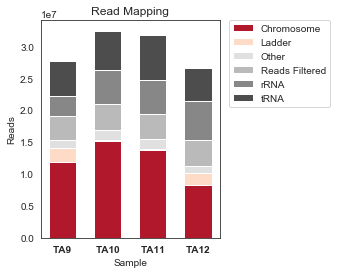

In [4]:
log_data = ribo_util.get_filter_bowtie_log(inputs, paths_in, paths_out)
ribo_plot.plot_alignment_allocation(inputs, paths_in, paths_out)

Read size distribution:

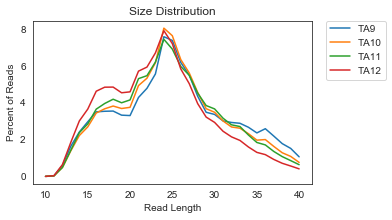

In [5]:
read_size_distribution = ribo_plot.size_dist(inputs, paths_in, paths_out)

Average nucleotide composition of reads:

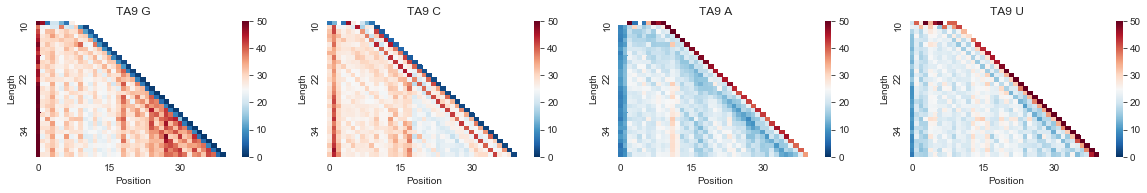

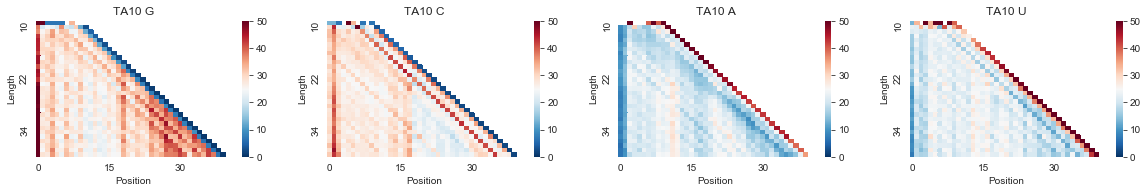

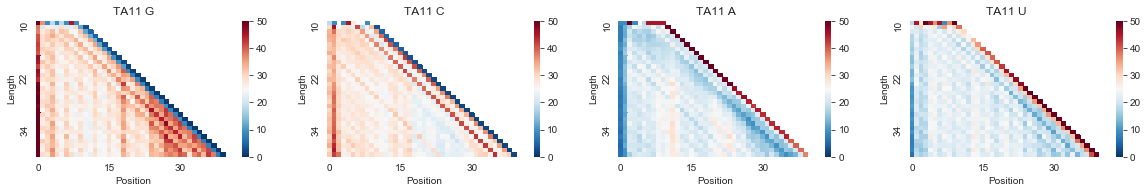

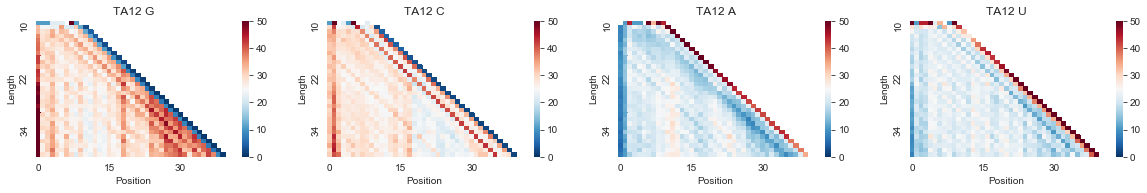

In [6]:
read_composition = ribo_plot.read_comp(inputs, paths_in, paths_out)    